In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys


import functions.parse_data as parse
import functions.handy_functions as hf
import torch.nn as nn
import torch

from multivariate_quantile_regression.network_model import QuantileNetwork

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from tqdm import tqdm

import os
import random

/tmp/ipykernel_4441/3911021086.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-03-11 12:52:18.578542: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-11 12:52:18.612258: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-11 12:52:

In [2]:
# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    # CUDA is available, so let's set default device to GPU
    torch.set_default_device(0)
    print("CUDA is available. Using GPU.")
else:
    # CUDA is not available, so let's use the CPU
    print("CUDA is not available. Using CPU.")

# Example usage:
tensor = torch.randn(3, 3)  # Create a tensor on the selected device
print("Tensor is on device:", tensor.device)

CUDA is available. Using GPU.
Tensor is on device: cuda:0


In [3]:
data_water=parse.parse('SMHIdata/cloudrm_water.dat')
data_water2=parse.parse('SMHIdata/cloudrm2_water.dat')
data_clear=parse.parse('SMHIdata/cloudrm2_clear.dat')
data_ice=parse.parse('SMHIdata/cloudrm_ice.dat')
data_ice2=parse.parse('SMHIdata/cloudrm2_ice.dat')
data_mixed=parse.parse('SMHIdata/cloudrm_mixed.dat')
data_mixed2=parse.parse('SMHIdata/cloudrm2_mixed.dat')

#Concatinate all datasets
data_all=pd.concat([data_water2, data_clear, data_ice2, data_mixed2])
data_all=data_all.drop(columns=['Surface_Desc','Cloud_B01','Clear_B01'])
df_truth=data_all.copy()
df_truth=df_truth.reset_index(drop=True)


In [4]:
##Train test validation split##
X_labels= ['Cloud_B02','Cloud_B03','Cloud_B04','Cloud_B05','Cloud_B06',
           'Cloud_B07','Cloud_B08','Cloud_B08A','Cloud_B09','Cloud_B10','Cloud_B11','Cloud_B12']

y_labels=['Clear_B02','Clear_B03','Clear_B04','Clear_B05','Clear_B06',
           'Clear_B07','Clear_B08','Clear_B08A','Clear_B09','Clear_B10','Clear_B11','Clear_B12']


##Split data##
X=df_truth[X_labels]
y=df_truth[y_labels]

X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.1,random_state=313)

np.random.seed(313)
X_test = X_test + np.random.randn(np.shape(X_test)[0],np.shape(X_test)[1]) * np.mean(X.to_numpy(),axis=0)*0.03

In [5]:
quantiles=np.array([0.1,0.5,0.9])
no_nodes=100
est= np.where(quantiles==0.5)[0].item()

sequence= lambda: nn.Sequential(
    nn.Linear(len(X_labels),no_nodes),
    nn.ReLU(),
    nn.Linear(no_nodes,no_nodes),
    nn.ReLU(),
    nn.Linear(no_nodes,no_nodes),
    nn.ReLU(),
    nn.Linear(no_nodes,no_nodes),
    nn.ReLU(),
    nn.Linear(no_nodes,no_nodes),
    nn.ReLU(),
    nn.Linear(no_nodes,no_nodes),
    nn.ReLU(),
    nn.Linear(no_nodes, len(quantiles)*len(y_labels)) #Output dimesion is number of quantiles times number of target variables
)

In [6]:
val_size=0.1
batch_size=500 

lr_s=[0.003]

num_models=5 #Set number of ensambles
batch_size=500
nepochs=1000
lr=0.003
noise_ratio = 0.03
early_break=True

looped_metric="Loop_learning_rate"
main_filepath='pytorch_models/'+looped_metric

model_metrics=pd.DataFrame(columns=['Ensemble_mean','Ensemble_index',looped_metric,'MSE','PSNR','R2_score','Mean_Quantile_Loss','Quant_Rate','Quantiles'])
for lr in lr_s:

    
    models=[QuantileNetwork(quantiles=quantiles) for _ in range(num_models)]
    preds_total=[]
    for i,model in enumerate(models): 

        validation_indices=np.array(random.sample(range(len(X_train['Cloud_B02'])), int(len(X['Cloud_B02'])*val_size)))
        train_indices=[i for i in range(len(X_train['Cloud_B02'])) if np.any(validation_indices==i)==False]       

        model.fit(X_train.to_numpy(),y_train.to_numpy(), 
            train_indices, 
            validation_indices, 
            batch_size=batch_size,
            nepochs=nepochs,
            sequence=sequence(),
            lr=lr,
            noise_ratio=noise_ratio,
            early_break=early_break)
        
        filepath=main_filepath+'/'+str(lr)+'/model'+str(i)
        os.makedirs(filepath,exist_ok=True)
        torch.save(model,filepath+'/model_file')

        preds = model.predict(X_test.to_numpy())
        if i==0:
            preds_total=preds
        else:
            preds_total=preds_total+preds

        mse=mean_squared_error(y_test.to_numpy(),preds[:,:,est])
        psnr=QuantileNetwork.PSNR(y_test,preds[:,:,est])
        r2=r2_score(y_test.to_numpy(),preds[:,:,est])
        mean_quantile=QuantileNetwork.mean_marginal_loss(y_test.to_numpy(),preds,quantiles)
        quant_rate=QuantileNetwork.quant_rate(y_test.to_numpy(),preds)

        tmp_metrics=pd.DataFrame(data=[[False,i,lr,mse,psnr,r2,mean_quantile,quant_rate,quantiles]],columns=['Ensemble_mean','Ensemble_index',looped_metric,'MSE','PSNR','R2_score','Mean_Quantile_Loss','Quant_Rate','Quantiles'])
        model_metrics=pd.concat([model_metrics,tmp_metrics])
    
    preds_total=preds_total/num_models

    mse=mean_squared_error(y_test.to_numpy(),preds_total[:,:,est])
    psnr=QuantileNetwork.PSNR(y_test,preds_total[:,:,est])
    r2=r2_score(y_test.to_numpy(),preds_total[:,:,est])
    mean_quantile=QuantileNetwork.mean_marginal_loss(y_test.to_numpy(),preds_total,quantiles)
    quant_rate=QuantileNetwork.quant_rate(y_test.to_numpy(),preds_total)

    tmp_metrics=pd.DataFrame(data=[[True,np.nan,lr,mse,psnr,r2,mean_quantile,quant_rate,quantiles]],columns=['Ensemble_mean','Ensemble_index',looped_metric,'MSE','PSNR','R2_score','Mean_Quantile_Loss','Quant_Rate','Quantiles'])
    model_metrics=pd.concat([model_metrics,tmp_metrics])


X_test.to_csv(main_filepath+'/xtest.csv',index=False)
y_test.to_csv(main_filepath+'/ytest.csv',index=False)

model_metrics=model_metrics.reset_index(drop=True)
model_metrics.to_csv(main_filepath+'/model_metrics.csv',index=False)

Epoch 221


Batch number: 100%|██████████| 320/320 [00:00<00:00, 370.05it/s]

Training loss [2.3571298] Validation loss [2.376847]
Epoch 222



Batch number: 100%|██████████| 320/320 [00:00<00:00, 326.90it/s]

Training loss [2.3528373] Validation loss [2.4185102]


---No improvement in 100 epochs, broke early---
Best model out of total max epochs found at epoch 122
With validation loss: 2.3712782859802246


In [7]:

model_metrics


,Ensemble_mean,Ensemble_index,Loop_learning_rate,MSE,PSNR,R2_score,Mean_Quantile_Loss,Quant_Rate,Quantiles
0,False,0,0.003,0.008005,20.995343,0.814867,0.481541,"[0.10739583333333333, 0.49821666666666664, 0.8...","[0.1, 0.5, 0.9]"
1,False,1,0.003,0.008049,20.971414,0.814168,0.483450,"[0.08197083333333334, 0.45245833333333335, 0.8...","[0.1, 0.5, 0.9]"
2,False,2,0.003,0.008142,20.921129,0.810702,0.485019,"[0.117625, 0.5491166666666667, 0.9112333333333...","[0.1, 0.5, 0.9]"
3,False,3,0.003,0.008082,20.953743,0.813048,0.484600,"[0.09406666666666667, 0.4941291666666667, 0.89...","[0.1, 0.5, 0.9]"
4,False,4,0.003,0.008218,20.880788,0.809164,0.491486,"[0.09271666666666667, 0.47733333333333333, 0.8...","[0.1, 0.5, 0.9]"
5,True,NaN,0.003,0.007650,21.191976,0.822905,0.465884,"[0.0764125, 0.4914875, 0.9192958333333333]","[0.1, 0.5, 0.9]"


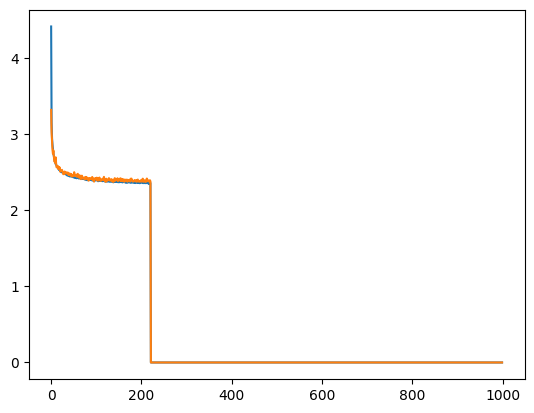

In [8]:
plt.figure()
plt.plot(model.train_loss.cpu())
plt.plot(model.val_loss.cpu())
plt.show()

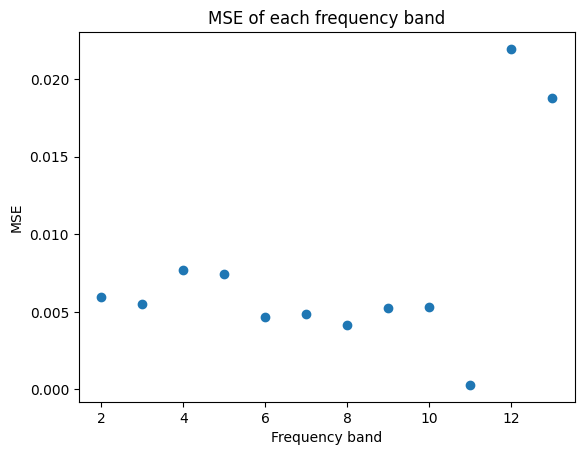

0.02193592997684702


In [9]:
MSE_col = np.mean((preds_total[:,:,est]-y_test.to_numpy())**2,axis=0)
x=np.arange(2,np.size(MSE_col)+2)
plt.figure()
plt.scatter(x,MSE_col)
plt.title('MSE of each frequency band')
plt.xlabel('Frequency band')
plt.ylabel('MSE')
plt.show()
print(MSE_col[10])

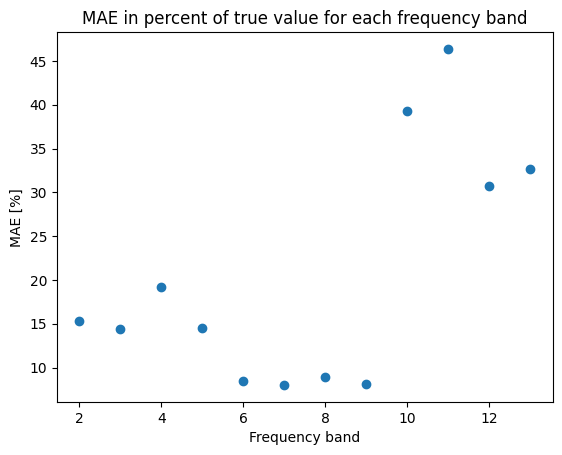

30.676859131153584


In [10]:
error_percent = 100*np.divide(np.abs(preds_total[:,:,est]-y_test.to_numpy()),y_test.to_numpy())

err_perc_col = np.mean(error_percent,axis=0)

plt.figure()
plt.scatter(x,err_perc_col)
plt.title('MAE in percent of true value for each frequency band')
plt.ylabel('MAE [%]')
plt.xlabel('Frequency band')
plt.show()
print(err_perc_col[10])

In [1]:
#Find COTs of all test points
testindices=y_test.index
COTs=np.array(df_truth['COT'].iloc[testindices])

#find sorted numpy indices and sort COT array
COTidx=np.argsort(COTs)
COT_sorted = COTs[COTidx]

#sort numpy test and preds by COT
y_test_np_sort=np.array(y_test)[COTidx,:]
y_pred_sort=preds_total[COTidx,:,:]

#Find errors and uncs for band 11
all_bands=False
if all_bands:
    errors2 = np.mean((y_test_np_sort[:,:]-y_pred_sort[:,:,est])**2,axis=1)
    uncs = np.mean(y_pred_sort[:,:,-1]-y_pred_sort[:,:,0],axis=1)
else:
    band = 10
    errors2 = (y_test_np_sort[:,band]-y_pred_sort[:,band,est])**2
    uncs = y_pred_sort[:,band,-1]-y_pred_sort[:,band,0]

#sort errors and uncs into bins based on COT
COTedges=np.linspace(0,50.5,102)
err2_bins = np.zeros(len(COTedges)-1)
unc_bins = np.zeros(len(COTedges)-1)
bin_freq = np.zeros(len(COTedges)-1)

for i in range(len(COT_sorted)):
    for j in range(len(COTedges)-1):   
        if COT_sorted[i] >= COTedges[j] and COT_sorted[i] < COTedges[j+1]:
            err2_bins[j] = err2_bins[j] + errors2[i]
            unc_bins[j] = unc_bins[j] + uncs[i]
            bin_freq[j] = bin_freq[j] + 1
            break

#Find mean errs and uncs in each bin
err2_mean_bins = err2_bins/bin_freq
unc_mean_bins = unc_bins/bin_freq

x=COTedges[:-1]+0.5
MSEplot = mse*np.ones(len(x))
plt.figure()
plt.plot(x,err2_mean_bins)
plt.plot(x,unc_mean_bins)
plt.plot(x,MSEplot)
plt.title('MSE and estimated uncertainty over COT values')
plt.legend(['Mean squared error for each COT','Mean uncertainty for each COT (quant 0.9-0.1)','MSE over whole set'])
plt.xlabel('COT')
plt.ylabel('Mean squared error/uncertainty')
plt.show()



NameError: name 'y_test' is not defined

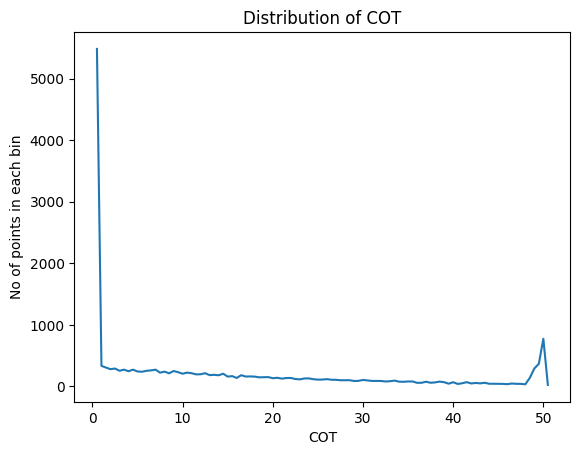

In [12]:
plt.figure()
plt.plot(x,bin_freq)
plt.title('Distribution of COT')
plt.ylabel('No of points in each bin')
plt.xlabel('COT')
plt.show()

In [13]:
psnr_11=QuantileNetwork.PSNR(y_test.to_numpy()[:,10],preds_total[:,10,est])
r2_11=r2_score(y_test.to_numpy()[:,10],preds_total[:,10,est])
mean_quantile=QuantileNetwork.mean_marginal_loss(y_test.to_numpy()[:,10],preds_total[:,10,:],quantiles)
quant_rate_11=QuantileNetwork.quant_rate(y_test.to_numpy()[:,10],preds_total[:,10,:])

print('PSNR for B11: '+str(psnr_11))
print('R2 for B11: '+str(r2_11))
print('MQL for B11: '+str(mean_quantile))
print('quant rate for B11: '+str(quant_rate_11))


PSNR for B11: 16.49040679983923
R2 for B11: 0.5653796540672891
MQL for B11: 0.0777514235804892
quant rate for B11: [0.08695 0.4946  0.92555]


In [14]:
np.mean(err_bins/bin_freq)

NameError: name 'err_bins' is not defined

In [ ]:
testindices = y_test.index
p1=testindices[0]
print(y_test.iloc[0])
print(df_truth[y_labels].loc[p1])


Clear_B02     0.18570
Clear_B03     0.17800
Clear_B04     0.27788
Clear_B05     0.13659
Clear_B06     0.33665
Clear_B07     0.96122
Clear_B08     0.84829
Clear_B08A    0.99260
Clear_B09     0.07497
Clear_B10     0.00027
Clear_B11     0.93285
Clear_B12     0.69242
Name: 117388, dtype: float64
Clear_B02     0.18570
Clear_B03     0.17800
Clear_B04     0.27788
Clear_B05     0.13659
Clear_B06     0.33665
Clear_B07     0.96122
Clear_B08     0.84829
Clear_B08A    0.99260
Clear_B09     0.07497
Clear_B10     0.00027
Clear_B11     0.93285
Clear_B12     0.69242
Name: 117388, dtype: float64
